# Диагностирование диабета методами машинного обучения

Задача заключается в предсказании наличия диабета у пациентов на основе их медицинских и демографических данных. То есть, используя информацию о пациентах, такую как возраст, пол, индекс массы тела (BMI), наличие гипертонии и сердечных заболеваний, история курения, уровень гликированного гемоглобина (HbA1c) и уровень глюкозы в крови, модель машинного обучения должна определить, есть ли у пациента диабет (положительный результат) или нет (отрицательный результат). Т.е. поставлена задача бинарной классификации.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Чтение данных

In [2]:
path = "data/diabetes_prediction_dataset.csv"
data = pd.read_csv(path)

In [3]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# 2. Визуализация и анализ

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
data['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [6]:
data['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [7]:
data['hypertension'].value_counts()

hypertension
0    92515
1     7485
Name: count, dtype: int64

In [8]:
data['heart_disease'].value_counts()

heart_disease
0    96058
1     3942
Name: count, dtype: int64

## Из данной информации можем сделать следующие выводы: 

* Не все столбцы являются числами
* Нечисловые столбцы являются категориальным
* Отсутствуют пропуски в явном виде, но в столбце smoking_history есть значение No info

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885856,22.516840,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,1.00


## Из числовых признаков:

* Средний возраст пациентов 42 года
* Есть пациент с возрастом 0.08 (наличие выбросов)
* Есть дисбаланс классов (91.5% здоровых на 8.5% больных пациентов) 

### Визуализация категориальных признаков:

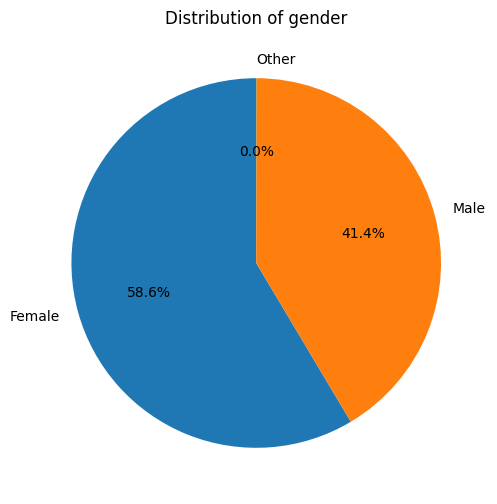

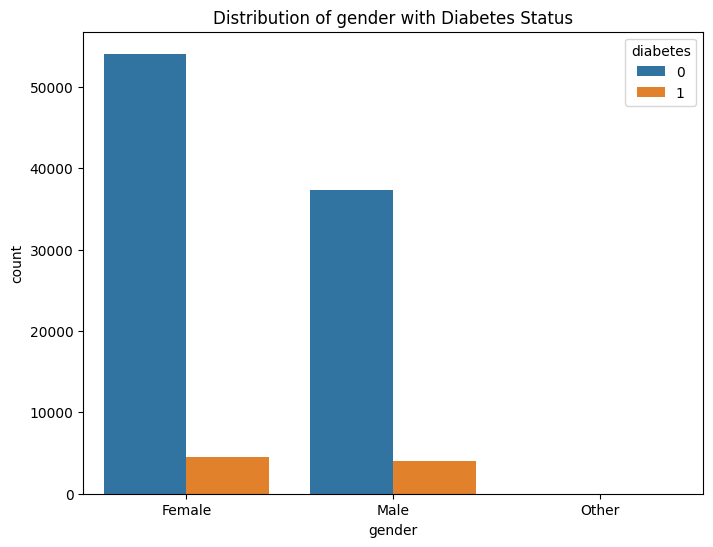

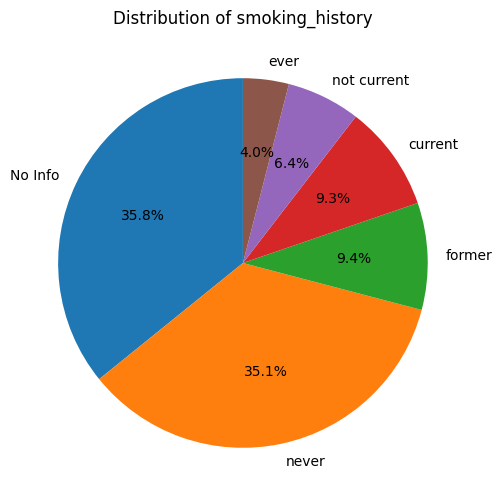

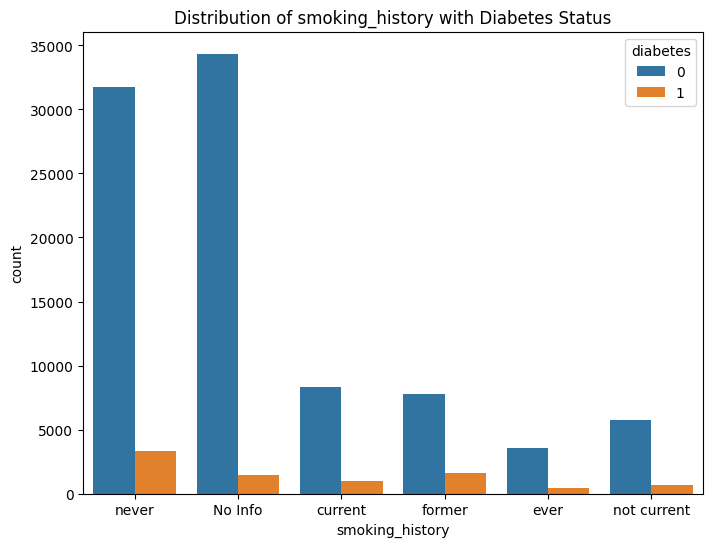

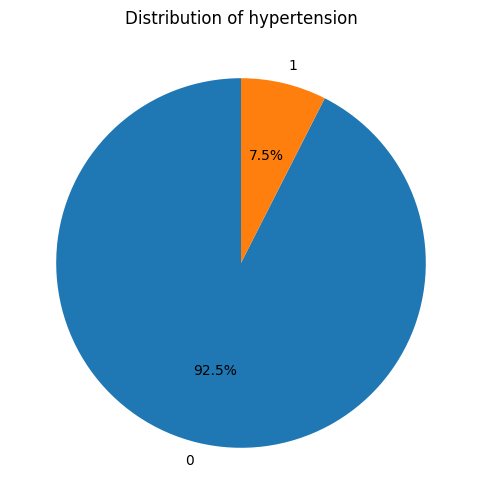

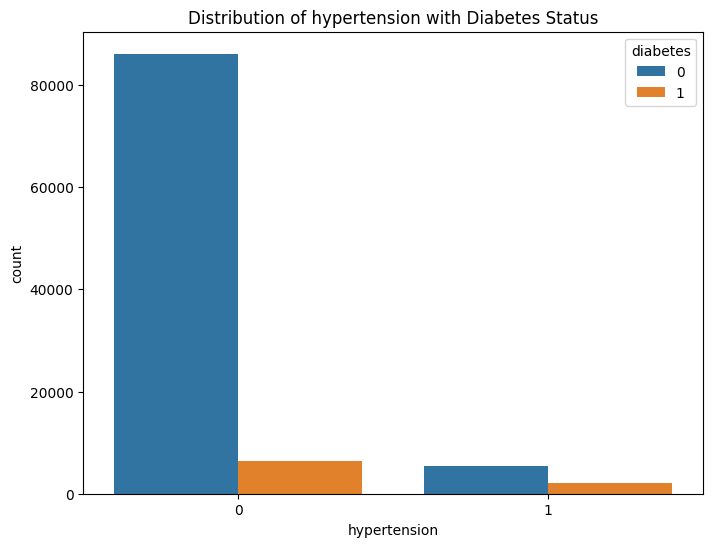

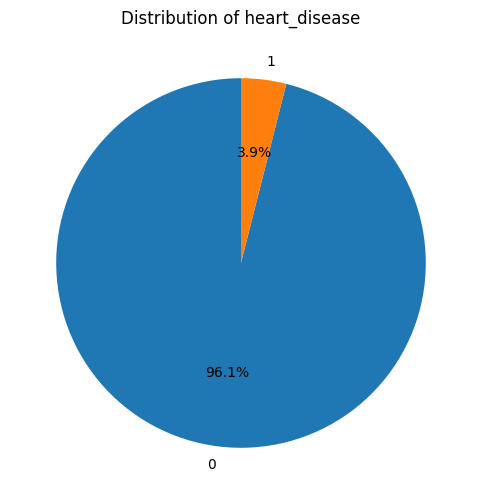

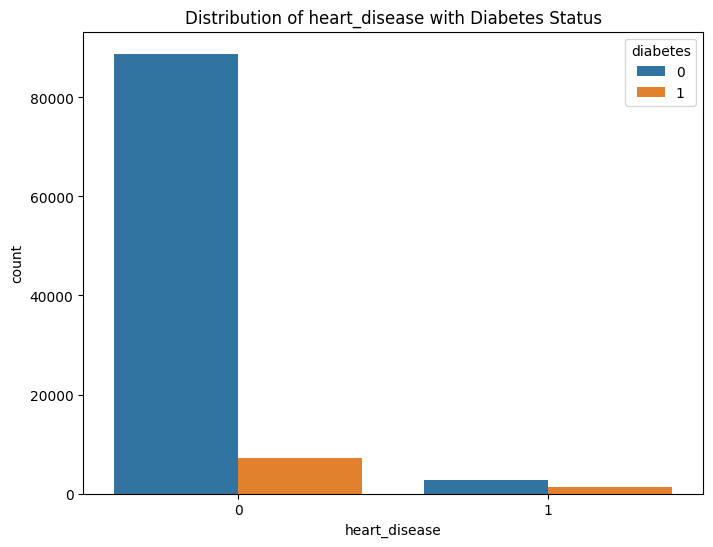

In [10]:
categorical_columns = ['gender','smoking_history','hypertension','heart_disease']

for column in categorical_columns:
  plt.figure(figsize=(8, 6))
  data[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
  plt.title(f'Distribution of {column}')
  plt.ylabel('')
  plt.show()
    
  plt.figure(figsize=(8, 6))
  sns.countplot(x=column, data=data, hue='diabetes')
  plt.title(f'Distribution of {column} with Diabetes Status')
  plt.show()

### Исходя из графиков:
* у мужчин риск заболевания выше
* Курящие люди (на данный момент или в прошлом) более подвержены заболеванию
* Вероятность диабета у людей с болезнями сердца также повышена

## Матрица корреляции признаков:

In [11]:
def draw_corr_matrix(df: pd.DataFrame, shape: int): # df-ваш датафрейм, shape - размер матрицы
    df = df.corr().copy()
    plt.rcParams["figure.figsize"] = shape,shape
    plt.imshow(df, cmap ='coolwarm')
    plt.colorbar()
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            text = plt.text(j, i, round(float(df.iloc[i, j]),2),
                        ha="center", va="center", color="r")
            
    plt.xticks(range(len(df)), df.columns, rotation = 45)
    plt.yticks(range(len(df)), df.index)
    plt.show()

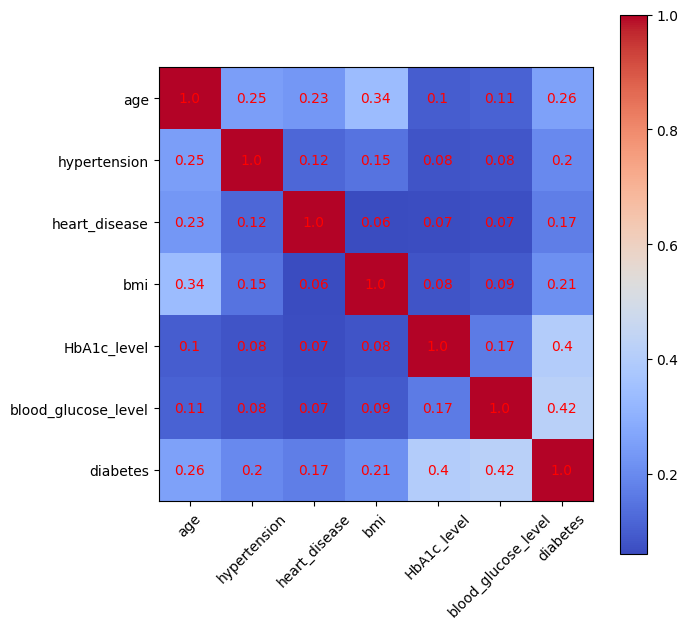

In [12]:
numeric_cols = data.select_dtypes(include='number').columns
draw_corr_matrix(data[numeric_cols], 7)

### Из корреляционной матрицы:
Наша целевая переменная наиболее скоррелирована с уровнем глюкозы и гликированного гемоглобина.
Стоит отметить, что корреляция есть со всеми числовыми признаками, следовательно для решения задачи будем использовать все столбцы.

## Иллюстрация зависимостей столбцов:

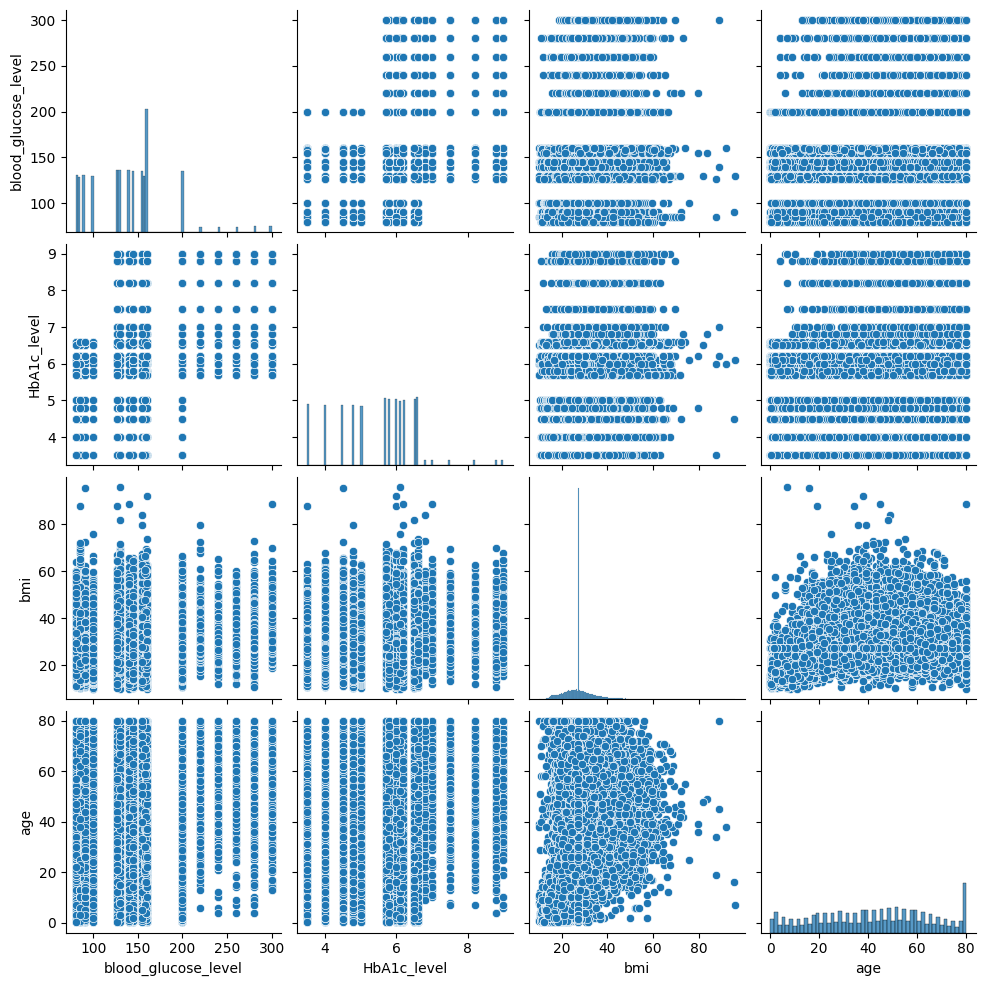

In [13]:
import matplotlib.pyplot as plt

numeric_cols = ['blood_glucose_level','HbA1c_level','bmi','age']
sns.pairplot(data[numeric_cols])

plt.show()

### Исходя и графиков:
* Среди пациентов есть дети самых малых возрастов
* У большого числа пациентов возраст 80 (вероятно все значения большие приравнялись к данному, либо значение использовалось по умолчанию)
* Подтвердилось наличие выбросов
* Есть связь между уровнем глюкозы и гликированного гемоглобина

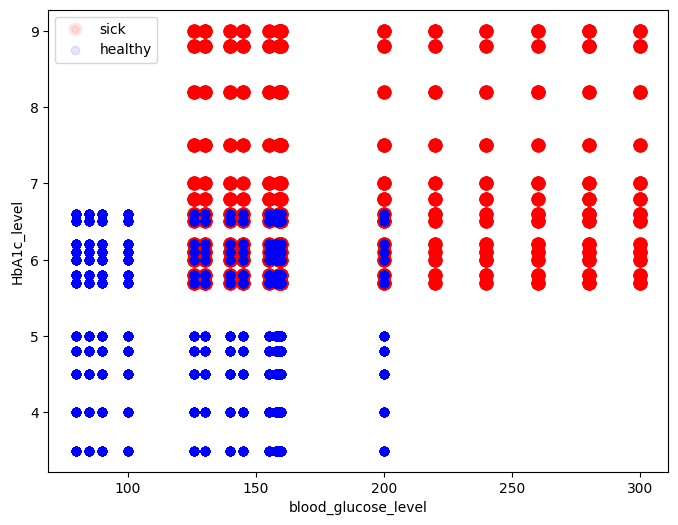

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(x=numeric_cols[0], y=numeric_cols[1], alpha = 0.1, c='r', lw=4, data=data[data['diabetes'] == 1.0], label='sick')
plt.scatter(x=numeric_cols[0], y=numeric_cols[1], alpha = 0.1, c='b', data=data[data['diabetes'] == 0.0], label='healthy')
plt.xlabel(f'{numeric_cols[0]}')
plt.ylabel(f'{numeric_cols[1]}')
plt.legend()
plt.show()

Из графика можно увидеть, что уже по этим двум показателям возможно классифицировать пациентов, однако есть значительная область, где они не различимы по данным признакам.

# 3. Борьба с выбросами, кодирование категориальных признаков, нормализация и разделение на train-test выборки

### Для борьбы с выбросами воспользуемся эвристическим правилом:
Все объекты за границами интервала $[Q_1 - 1.5 \cdot IQR;Q_3+ 1.5 \cdot IQR]$ являются выбросами

In [15]:
startrows = data.shape[0]

for column in numeric_cols:
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

rows_dropped = startrows-data.shape[0]

print(f'{rows_dropped} rows dropped')

10019 rows dropped


### Применение One-Hot кодирования для категориальных признаков:

In [16]:
data = pd.get_dummies(data, columns=['gender', 'smoking_history'])

In [17]:
data.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,True,False,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,True,False,False,True,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,False,True,False,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,True,False,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,False,True,False,False,True,False,False,False,False


### Нормализация данных:

In [18]:
X = data.drop(['diabetes'], axis=1)
Y = data['diabetes']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

### Train-Test разделение данных:

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 4. Применение алгоритмов машинного обучения

### Метод K-ближайших соседей
Данный метод будем использовать в качестве base-line модели

In [20]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)
y_pred_train = KNN.predict(X_train)
y_pred_test = KNN.predict(X_test)

In [21]:
err_train = 1 - KNN.score(X_train, y_train)
err_train

0.02940931318070683

In [22]:
err_test = 1 - KNN.score(X_test, y_test)
err_test

0.036450519531032954

В результате ошибка составляет порядка 3.6%, что в целом хороший показатель при решении задачи методами машинного обучения, однако в случае области медицины требования к алгоритмам гораздо строже (желательно добиться точности 98-99%)

### Воспользуемся методом перебора гиперпараметров для количества ближайших соседей:

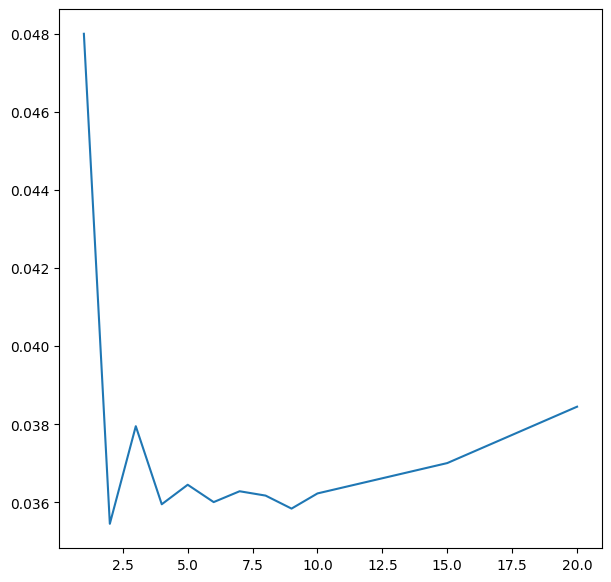

In [23]:
n_neighbors = [1,2,3,4,5,6,7,8,9,10,15,20]
errs = []
for n in n_neighbors:
    KNN = KNeighborsClassifier(n_neighbors=n)
    KNN.fit(X_train, y_train)
    y_pred_test = KNN.predict(X_test)
    errs.append(1 - KNN.score(X_test, y_test))

plt.plot(n_neighbors, errs)

In [24]:
print('Минимальная ошибка: ',np.min(errs), ' для n = ', n_neighbors[np.argmin(errs)])

Минимальная ошибка:  0.03545035283658382  для n =  2


Из графика следует, что оптимальным гиперпараметром метода является n = 2

### Классификатор Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 500)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

err_test = 1 - rfc.score(X_test, y_test)
err_test

0.027560148913707838

Ошибка составила 2.75%, что несомненно лучше предыдущего метода, однако Random Forest является ансамблем более простых моделей, поэтому его применение дороже в вычислительном плане и по затратам памяти.

# Выводы

Предварительный анализ данных, их обработка и применение к ним моделей машинного обучения дали достойный результат (ошибка 2.75% на тестовой выборке). Однако для задачи медицины требуется максимальная точность. Для увеличения точности следует рассмотреть следующие шаги:
* борьба с дисбалансом классов
* эксперименты с другими моделями, подбор лучших гиперпараметров